In [1]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

from tensorflow import keras

from keras import Input, layers
from keras.preprocessing import image
from keras.layers import Reshape
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model

from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences

from keras.models import load_model

## model for feature extract

In [2]:
model_inception = InceptionV3(weights='imagenet')

In [3]:
model_featureExtr = Model(model_inception.input, model_inception.layers[-2].output)

In [4]:
caption_model = load_model('expresso_model.h5')

In [5]:
max_length = 38

In [6]:
vocab = open('vocab.txt', 'r').read().strip().split('\n')

ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [7]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [8]:
def encode(image_byme):
    image = preprocess(image_byme) 
    fea_vec = model_featureExtr.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

In [9]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        #print(sequence)
        sequence = pad_sequences([sequence], maxlen=max_length)
        sequence = np.array(sequence)
        yhat = caption_model.predict([photo,sequence], verbose=0) #here we must pass the encoded image otw error show failed to find data adapter
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [10]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = caption_model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

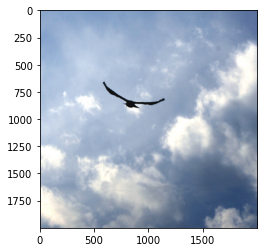

In [11]:
image_byme = '../testingImage/singlebird.jpg'

encoded_img = encode(image_byme)
encoded_img = encoded_img.reshape(1,2048)
x=plt.imread(image_byme)
plt.imshow(x)
plt.show()

In [12]:
print("Greedy Search:=========>",greedySearch(encoded_img))
print("Beam Search(K=10):=====>",beam_search_predictions(encoded_img, beam_index = 10))

Greedy Search:=========> a small black and white bird is standing on the grass
Beam Search(K=10):=====> a small black and white bird take flight from a body of water
